# Data Project - Demography

The following project concerns the study of demography and the composition of the population divided into age and gender. The underlying data for this project is based on past data and projections for the future.
Please note that genereally there is a statistic uncertainty regarding the projections,since they are based on assumptions made for future developments in fertility, mortality and migration. This is subject to uncertainty. The further out in the future, the greater the uncertainty is.
The data, which is being used in this project is fetched directly from the two data sets "FRDK118" and "FOLK2" from Danmarks Statistik, DST.

The data will be visualized in the form of an interactive population pyramid, showing the age and gender distribution throughout the years spanning from 1980 to 2060 for the total population of Denmark.

**!! Before running the project, the package “plotly” and "pydst" should be installed!!**

Paste *pip install plotly* in the Terminal. This is a necessity in order to view the figures and tables. 
See https://plot.ly/python/getting-started/ for help.

Paste *pip install git+https://github.com/elben10/pydst* in the Terminal.


### Post feedback changes

Most feedback regarding our project commented on the lack of showing of each change made our dataframes and lack of comments. This have been the main focus when improving this project.

* Improved comments and formating on each cell
* Improved reasoning for pickle format
* Splitted up cells to show output more often
* Constructed a stacked histogram showing the distribution between the age grousps

# The data

Due to the big amount of Data the csv files contain, we have made us of the pickle format in order to reduce processing and waiting time for our viewers. First we will create a file path "pickles", if it doensn't already exist. 

In [1]:
# Import relevant packages
import os
import pydst
import pandas as pd
import numpy as np

In [2]:
# Set language to Danish 
dst = pydst.Dst(lang='da')

# make pickle path if not already existing
try:
    os.makedirs("pickles")
except:
    pass

## Fetch data from DST  ##
First the two data sets are being fetched directly from DST and saved as pickles to speed up the computing. The columns are renamed as well. We're also gonna map (return a new list) of Males and females and changes years, which was first presented as strings into intergers.

**It might take some time to fetch the data the first time you are running this code!**

In [3]:
#########################
# POPULATION PROJECTION #
#########################

population_projection = None
# If if a pickle exists, unpickle it
if os.path.isfile("pickles/population_projection.pickle"):
    population_projection = pd.read_pickle("pickles/population_projection.pickle")
# otherwise get and process the data anew
else:
    raw_data = None
    # If path exisit, save the data as a dataframe
    if os.path.isfile("pickles/raw_data_frdk118.pickle"):
        raw_data = pd.read_pickle("pickles/raw_data_frdk118.pickle")
    else:
        # Fetch data from DST and save as raw_data
        raw_data = dst.get_data(
            table_id = 'FRDK118', # table id from DST
            variables={ #  Import these variables with all their input
                "KØN" : ["*"],
                "ALDER" : ["*"], 
                "TID" :["*"], 
                "HERKOMST" : ["*"]})
        raw_data.to_pickle("pickles/raw_data_frdk118.pickle") # Save data to pickle


    #create a copy
    population_projection = raw_data.copy()

    # rename columns
    population_projection = population_projection.rename(columns = {
        "KØN": "gender",
        "ALDER": "age",
        "TID": "year",
        "HERKOMST": "origin",
        "INDHOLD": "count"
    })
    
    # map gender to M/F
    population_projection["gender"] = population_projection["gender"].map({
        "Mænd": "M",
        "Kvinder": "F"
    })
    
     # map dst's year to actual int years from strings.
    population_projection["age"] = population_projection["age"].map(lambda year : int(year.split(' ', 1)[0]))
    
    # save to pickle
    population_projection.to_pickle("pickles/population_projection.pickle")

Let's see how this dataframe looks.

In [4]:
# Look up first 10 entries
population_projection.head(10)

,gender,age,year,origin,count
0,M,28,2058,Personer med dansk oprindelse,32466
1,F,29,2058,Personer med dansk oprindelse,30918
2,M,29,2058,Personer med dansk oprindelse,32423
3,F,30,2058,Personer med dansk oprindelse,30863
4,M,30,2058,Personer med dansk oprindelse,32375
5,F,31,2058,Personer med dansk oprindelse,30745
6,M,31,2058,Personer med dansk oprindelse,32216
7,F,32,2058,Personer med dansk oprindelse,30511
8,M,32,2058,Personer med dansk oprindelse,31983
9,F,33,2058,Personer med dansk oprindelse,30118


Now we wanna group the data by gender, age and year in order to remove the origin column, which is not relevant in this project.

In [5]:
## Group data by gender, age and year then sum over count
population_projection_grouped = population_projection.groupby(["gender", "age", "year"])
population_projection_grouped_sum = population_projection_grouped.agg("sum").reset_index()

Let's see what's changed.

In [6]:
# Project first 10 entries of new dataframe
population_projection_grouped_sum.head(10)

,gender,age,year,count
0,F,0,2018,30107
1,F,0,2019,31435
2,F,0,2020,31978
3,F,0,2021,32507
4,F,0,2022,33053
5,F,0,2023,33646
6,F,0,2024,34272
7,F,0,2025,34824
8,F,0,2026,35201
9,F,0,2027,35405


Now we have fetched and made admentments to the population projection data. Now we will do the excact same for the population history data.

In [7]:
#########################
# POPULATION HISTORY #
#########################


# if a pickle exists, unpickle it
population_history = None
if os.path.isfile("pickles/population_history.pickle"):
    population_history = pd.read_pickle("pickles/population_history.pickle")
 # otherwise get and process the data anew
else:
    raw_data = None
    if os.path.isfile("pickles/raw_data_folk2.pickle"): # If path exist
        raw_data = pd.read_pickle("pickles/folk2.pickle") # Create dataframe
    else:
        # Fetch data from DST and save as raw_data
        raw_data = dst.get_data(
            table_id = 'FOLK2',
            variables={
                "KØN" : ["*"],
                "ALDER" : ["*"], 
                "TID" :["*"], 
                "HERKOMST" : ["*"], 
                "STATSB" : ["*"],
                "IELAND" : ["*"]})
        raw_data.to_pickle("pickles/raw_data_folk2.pickle")

    # create a copy
    population_history = raw_data.copy()
    
    # rename columns
    population_history = population_history.rename(columns = {
        "KØN": "gender",
        "ALDER": "age",
        "TID": "year",
        "HERKOMST": "origin",
        "STATSB" : "citizenship",
        "IELAND" : "country of origin",
        "INDHOLD": "count"
    })
    
    # map gender to M/F
    population_history["gender"] = population_history["gender"].map({
        "Mænd": "M",
        "Kvinder": "F"
    })
    
     # map dst's year to actual int years from strings.
    population_history["age"] = population_history["age"].map(lambda year : int(year.split(' ', 1)[0]))
    
    # save to pickle
    population_history.to_pickle("pickles/population_history.pickle")


And how does it look?

In [8]:
# Project first 10 entries
population_history.head(10)

,gender,age,year,origin,citizenship,country of origin,count
0,F,14,2013,Efterkommere,Udenlandsk,Finland,1
1,F,14,2013,Efterkommere,Udenlandsk,Island,13
2,F,14,2013,Efterkommere,Udenlandsk,Norge,2
3,F,14,2013,Efterkommere,Udenlandsk,Sverige,7
4,F,14,2013,Efterkommere,Udenlandsk,Bulgarien,2
5,F,14,2013,Efterkommere,Udenlandsk,Frankrig,2
6,F,14,2013,Efterkommere,Udenlandsk,Nederlandene,23
7,F,14,2013,Efterkommere,Udenlandsk,Irland,1
8,F,14,2013,Efterkommere,Udenlandsk,Italien,2
9,F,14,2013,Efterkommere,Udenlandsk,Serbien og Montenegro,2


## More data editing
Next the unnecessary columns are being removed by grouping over the desired columns. There were two overlapping years, which are being removed as well.

In [9]:
## Group data by gender, age and year then sum over count

population_history_grouped = population_history.groupby(["gender", "age", "year"])
population_history_grouped_sum = population_history_grouped.agg("sum").reset_index()


In [10]:
# Let's have a peek
population_history_grouped_sum.head(10)

,gender,age,year,count
0,F,0,1980,28886
1,F,0,1981,27959
2,F,0,1982,25993
3,F,0,1983,25678
4,F,0,1984,24915
5,F,0,1985,25302
6,F,0,1986,26386
7,F,0,1987,26938
8,F,0,1988,27177
9,F,0,1989,28498


In [11]:
## Delete the overlapping years
population_history_grouped_sum = population_history_grouped_sum[population_history_grouped_sum["year"] != 2019]
population_history_grouped_sum = population_history_grouped_sum[population_history_grouped_sum["year"] != 2018]

In [12]:
population_history_grouped_sum.head(10)

,gender,age,year,count
0,F,0,1980,28886
1,F,0,1981,27959
2,F,0,1982,25993
3,F,0,1983,25678
4,F,0,1984,24915
5,F,0,1985,25302
6,F,0,1986,26386
7,F,0,1987,26938
8,F,0,1988,27177
9,F,0,1989,28498


Now that we have both dataframes formated excactly the same way. We will append the projected population data into the population history and create our concatenated dataframe

In [13]:
## Create a variable that contains all data by concatenating the two data sets
population = population_history_grouped_sum.append(population_projection_grouped_sum)

In [14]:
population.head(10)

,gender,age,year,count
0,F,0,1980,28886
1,F,0,1981,27959
2,F,0,1982,25993
3,F,0,1983,25678
4,F,0,1984,24915
5,F,0,1985,25302
6,F,0,1986,26386
7,F,0,1987,26938
8,F,0,1988,27177
9,F,0,1989,28498


Now we are gonna seperate the two genders into two seperate variables.

In [15]:
# Seperates the two genders by creating two seperate variables.
pop_men = population[population["gender"] == 'M']
pop_women = population[population["gender"] == 'F']

Which look like this

In [16]:
pop_men.head(10)

,gender,age,year,count
4345,M,0,1980,30347
4346,M,0,1981,29207
4347,M,0,1982,26987
4348,M,0,1983,26964
4349,M,0,1984,25929
4350,M,0,1985,26499
4351,M,0,1986,27445
4352,M,0,1987,28447
4353,M,0,1988,29013
4354,M,0,1989,30299


## Create dictionary for each year
Our next will be to create a dictionary, which for each year contains a tuple of men and women for each age.

In [17]:
# Find min and max value for the column "year"
min_year = np.min(population['year'])
max_year = np.max(population['year'])

# create dictionary for each year
year_to_pop = {} # Create a empty dictionary
for i in range(min_year,max_year + 1): # for each year
    year = str(i) # make each entry a string
    # and loop over each year and make the count of males and females to two arrays  
    men = np.array(pop_men[pop_men["year"] == i]["count"].tolist()) 
    women = np.array(pop_women[pop_women["year"] == i]["count"].tolist())
    year_to_pop[year] = (men, women)

Let's see how this looks for the year 1980.

In [18]:
year_to_pop["1980"]

(array([30347, 31791, 31780, 33736, 36663, 36275, 36550, 38221, 38484,
        36180, 36498, 37985, 41131, 44601, 43190, 42181, 41521, 39106,
        38485, 38448, 37470, 37844, 38098, 38462, 38570, 37873, 38932,
        38209, 37948, 38823, 38859, 41306, 44085, 45948, 44900, 42760,
        39174, 37159, 33161, 32185, 31208, 30819, 29811, 28995, 28182,
        27747, 27022, 26840, 26760, 27040, 26311, 27477, 26879, 27309,
        27309, 27989, 27722, 27087, 28500, 29226, 25129, 25748, 24417,
        24208, 23416, 23950, 23412, 23342, 22043, 21294, 20692, 18961,
        17369, 16139, 14957, 13800, 12560, 11667, 10430,  9271,  8030,
         7439,  6407,  5633,  4875,  4134,  3414,  2549,  2235,  1718,
         1312,  1012,   769,   502,   366,   267,   147,   115,    69,
           43,    19,    12,     6,     2,     1]),
 array([28886, 30373, 30379, 31868, 35477, 34876, 34990, 36846, 36330,
        34598, 34495, 35859, 39380, 42497, 41145, 39933, 39744, 37510,
        36993, 36882, 357

We see how this year contains two arrays, which consist the amount of men and women for each age.

# The visualization
The data is being visualized through a population pyramid.
Some of the advantages of using a population pyramid is the following:
* One gets an insight into the composition of the population subdivided into age and gender (<16, 16-66, >66) 
* Indicates type of population structure, which can be used for future predictions 
* It shows whether the population surplus is due to men or women
* The population can reveal changes in birth and death rates
* It can reveal the impact of migration and events (i.e. epidemics and war)


In [19]:
# Import more packages for visualization
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets


py.offline.init_notebook_mode(connected=True)

## Creating the population pyramid
An interactive population pyramid is begin created together with a slider, which allows you to see the change of the population structure for each year.
We will first create an empty dictionary, data, then for each men and women in our year_to_pop tuple, we will reate 4 bars. 1 for men, 1 for women, 1 for inverted men, and 1 for inverted women. The two latter will help us see the different gaps in gender distribution for each year.

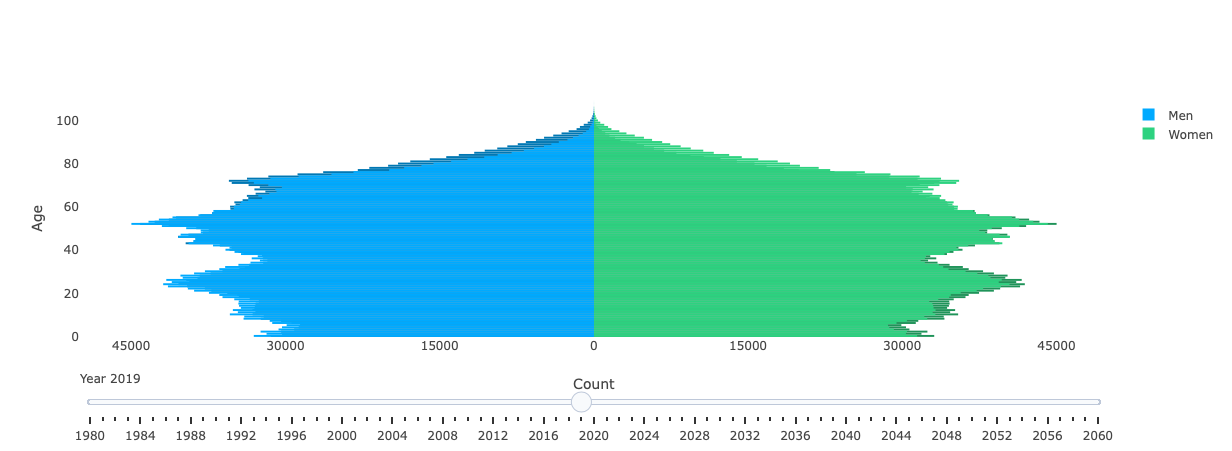

In [20]:
# the year the graph will initially show
initial_year = 2019

# the y range
y = list(range(0, 120, 1))

# colours for pyramid 
lightblue = "hsl(200, 100%, 50%)"
darkblue = "hsl(200, 100%, 35%)"
lightgreen = "hsl(150, 65%, 50%)"
darkgreen = "hsl(150, 65%, 35%)"

# Create four bars using the year_to_pop data.
data = []

for year, (men, women) in year_to_pop.items():
    # Create inverted bars 
    (men_inv, women_inv) = (men * -1, women * -1)
    # Create string of year
    isVisible = year == str(initial_year)
    data.extend([
        # Create bar for inverted women
        go.Bar(y=y,
               x=women_inv,
               visible = isVisible,
               orientation='h',
               hoverinfo='none',
               showlegend=False,
               marker=dict(color=darkblue)               ),
        # Create bar for inverted women
        go.Bar(y=y,
               visible = isVisible,
               x=men_inv,
               orientation='h',
               name='Men',
               hoverinfo='x',
               marker=dict(color=lightblue)
               ),
        # Create bar for men
        go.Bar(y=y,
               x=men,
               visible = isVisible,
               orientation='h',
               showlegend=False,
               hoverinfo='none',
               marker=dict(color=darkgreen)
               ),
        # Create bar for women
        go.Bar(y=y,
               x=women,
               visible = isVisible,
               orientation='h',
               name='Women',
               hoverinfo='x',
               marker=dict(color=lightgreen)
               )
    ])
    
# Construct the slider

# Create empty array
steps = []

# Loop over each year
for i in range(len(year_to_pop)):
    year = dict(
        method = "restyle",
        args = ["visible", [False] * len(year_to_pop) * 4],
        label=str(i + 1980)
    )
    year["args"][1][i*4 + 0] = True
    year["args"][1][i*4 + 1] = True
    year["args"][1][i*4 + 2] = True
    year["args"][1][i*4 + 3] = True
    steps.append(year)

sliders = [dict(
    active = initial_year - 1980,
    currentvalue = {"prefix": "Year "},
    pad = {"t": 30},
    steps = steps
    
)]
## Layout of the pyramid
layout = dict(
    sliders = sliders,
    yaxis = go.layout.YAxis(title = "Age"),
    xaxis = go.layout.XAxis(
        range = [-40000, 40000],
        tickvals = [-45000, -30000, -15000, 0, 15000, 30000, 45000],
        ticktext = [45000, 30000, 15000, 0, 15000, 30000, 45000],
        title = "Count",
        autorange = True,
    ),
    barmode = "overlay",
    bargap = 0.1
)

    
fig = go.Figure(data=data, layout=layout)

py.offline.iplot(fig)

The above population pyramid shows the distribution of age and gender throughout the years. The darker coloured bars show the difference between men and women for a given year. E.g. The dark blue coloured bars represent the excess amount of women compared to men.

As we slide through the years, we see a growing amount of elders above the age of 66 and a smaller workforce.

## Table visualization ##
In order to see the development more precisely, the table below also shows the change in structure of the population throughtout the years.

In [21]:
# Create a table 
def create_table(data):
    men, women = data
    pop = [sum(ns) for ns in zip(men, women)]
    dist = {}
# Count loop for three age groups
# If the age is xxx sum and go to next year.
    for age, count in enumerate(pop):
        if age < 16:
            dist["u16"] = dist.get("u16", 0) + count
            continue
        elif age < 66:
            dist["u66"] = dist.get("u66", 0) + count
        else:
            dist["o66"] = dist.get("o66", 0) + count

    total = sum(dist.values())
    
    # Construct percentages
    percentages = { k: f"{(count / total * 100):.2f}%" for k, count in dist.items() }
    dist = { k: f"{(count/1000):.2f}" for k, count in dist.items() }
    
    # Create the table by constructing a DataFrame with the below values
    frame = pd.DataFrame(
        data = {
            "Age": ["66+", "16-66", "<16", "Total"],
            "Thousands": [dist["o66"], dist["u66"], dist["u16"], total / 1000],
            "Percentages": [percentages["o66"], percentages["u66"], percentages["u16"], "100%"]
        }
    )

    return frame

Now we can create a table, which will show three age groups, <16, 16-66 and 66+, how many thousands individuals are in each group, and the underlying percentages. This will help us see the distribution of the Danish demographics.

In [22]:
## Layout for table and interactive slider
#Import more packages
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def render(year):
    return create_table(year_to_pop[str(year)])

# Create slider, which slides through years
slider = widgets.IntSlider(
    value=2019,
    min=1980,
    max=2060,
    step=1,
    description='Year:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

interact(render, year=slider);

interactive(children=(IntSlider(value=2019, description='Year:', max=2060, min=1980), Output()), _dom_classes=…

The table above clearly shows that the percentage of people under the age of sixteen has been falling since 1980 and is projected to continue to do so all the way until 2060. The percentage of people in the workforce from the age 16-66 was increasing until 1994 but has ever since had a downward slope and is projected to continue like this. Elders above the age of 66 have continuously increased.

## Stacked histogram
The above table will also be visualised as a stacked histogram.

In [23]:
def get_histogram(frame):
    return [float(p.strip('%')) / 100 for p in frame["Percentages"].tolist()]

In [24]:
def create_histogram(data):
    men, women = data
    pop = [sum(ns) for ns in zip(men, women)]
    dist = {}
# Count loop for three age groups
# If the age is xxx sum and go to next year.
    for age, count in enumerate(pop):
        if age < 16:
            dist["u16"] = dist.get("u16", 0) + count
            continue
        elif age < 66:
            dist["u66"] = dist.get("u66", 0) + count
        else:
            dist["o66"] = dist.get("o66", 0) + count

    total = sum(dist.values())
    
    # Construct percentages
    percentages = { k: count / total * 100 for k, count in dist.items() }
    dist = { k: (count/1000) for k, count in dist.items() }
    
    # Create the table by constructing a DataFrame with the below values
    frame = np.array(percentages['u16'])

    return frame

In [25]:
# Create empty list and append three sublist into it
histogram = []

for year, data in year_to_pop.items():
    frame = create_table(data)
    sub_histogram = get_histogram(frame)
    histogram.append(sub_histogram[:3])
    
my_histogram = np.array(histogram)

# Create an array for each subgroup
histoo66 = my_histogram[:,0]
histou66 = my_histogram[:,1]
histou16 = my_histogram[:,2]

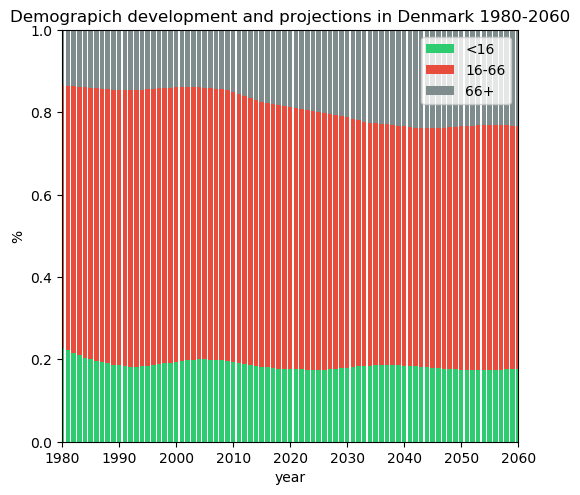

In [26]:
## Construct the histogram
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,12), dpi = 100)

# Labels
labels = ['<16','16-66','66+']

# Colors
life = "#2ecc71"
communism = '#e74c3c'
elderly = '#7f8c8d'

# Add a subplot for each good
ax1 = fig.add_subplot(2,3,1)

# x range
N = len(histou16)
ind = np.arange(N) + 1980
width = 0.8

u16 = ax1.bar(ind, histou16, width, color=life)
u66 = ax1.bar(ind, histou66, width, bottom = histou16, color=communism)
o66 = ax1.bar(ind, histoo66, width, bottom = histou16 + histou66, color=elderly)
plt.legend((u16[0], u66[0], o66[0]), (labels[0], labels[1],labels[2]))
ax1.set_title('Demograpich development and projections in Denmark 1980-2060')
ax1.set_xlabel('year')
ax1.set_ylabel('%')
plt.axis([1980, 2060, 0, 1])

plt.show()    

The above histogram also shows how the elderly is projected to continue to grow.

## Consequences of the demographic development 

The demographic development has a huge impact for the public sector and finance.
The increasing amount elders will affect the public expenditure, meaning the increasing amount of people receiving public pension. The tax revenue will be affected by the diminishing amount of people in the workforce. 
